In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

### Training time experiment with  sample size

In [5]:
experiment_name='sample_size_vs_train_time'

In [3]:
import numpy as np
import torch
import pyro

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
pyro_seed= 68
seed=1729

In [4]:
from scm import SCM 
from full_model import conditionalscm
from partial_model import conditionalscm_partial
import pandas as pd
from config import lr,weight_decay,epochs,log_interval,lr_annealing

In [15]:
sample_sizes=[256,1024,4096,8192,16384,32768 ]        #,5000,10000,20000,50000]


 We modify the trianing function here . We don't save training logs for this experiment.

In [16]:
import os
import time
import torch
import shutil
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from utils import mkdir

from data import get_features_dataset 
#from config import *

#NUM_WORKERS=12

def milestone_step( optimizer, epoch):
    if epoch in [epochs*0.5, epochs*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1


#def save_checkpoint(state, is_best, filepath):
#    mkdir(filepath)
#    torch.save(state, os.path.join(filepath, 'flow_ckpt.pth.tar'))
#    if is_best:
#        shutil.copyfile(os.path.join(filepath, 'flow_ckpt.pth.tar'), os.path.join(filepath, 'flow_best.pth.tar'))
        #print('best is saved')
#---------------------------------------------------------------------------------------------------------------


def train( model, optimizer, train_loader, epoch, print_mode=True):
    avg_loss = 0.
    for batch_idx, (X6,X5,X4,X3, X2, X1,Y) in enumerate(train_loader):
        X6, X5, X4, X3, X2, X1,Y = X6.reshape([-1,1]), X5.reshape([-1,1]), X4.reshape([-1,1]), X3.reshape([-1,1]), X2.reshape([-1,1]), X1.reshape([-1,1]), Y.reshape([-1,1]) 
        optimizer.zero_grad()
        log_p = model(X6, X5, X4, X3 ,X2, X1,Y)
        loss = -torch.mean(log_p['X_6']+log_p['X_5']+log_p['X_4']+log_p['X_3']+log_p['X_2']+log_p['X_1'] +log_p['Y'])
        avg_loss += loss.item()
        loss.backward()
        optimizer.step()
        model.clear()

    avg_loss /= -len(train_loader)
    #if epoch % log_interval ==0 and print_mode==True:
        #print('Epoch:',epoch,'\nTrain set: Average LogProb: {:.6f}\n'.format(avg_loss))
    
            
            

def test(model, test_loader):
    test_loss = 0.
    model.eval()
    associative_power ={'X_6':0,'X_5':0,'X_4':0,'X_3':0,'X_2':0,'X_1':0,'Y':0}
    for X6, X5, X4, X3, X2, X1,Y in test_loader:
        with torch.no_grad():
            X6, X5, X4, X3, X2, X1,Y = X6.reshape([-1,1]), X5.reshape([-1,1]), X4.reshape([-1,1]), X3.reshape([-1,1]), X2.reshape([-1,1]), X1.reshape([-1,1]), Y.reshape([-1,1]) 
            log_p = model(X6, X5, X4, X3 ,X2, X1,Y)
            test_loss += torch.mean(log_p['X_6']+log_p['X_5']+log_p['X_4']+log_p['X_3']+log_p['X_2']+log_p['X_1'] +log_p['Y'])
            for k,v in log_p.items():
                associative_power[k]+=torch.mean(v)
                #print(k,v)
                
                
    #print('length',len(test_loader))            
    test_loss /= len(test_loader)   #len(test_loader.dataset)
    associative_power=dict(associative_power) 
    associative_power={k: v/len(test_loader) for k,v in associative_power.items()}

    return test_loss, associative_power



def main(model_name,filepath=None,seed=None,data=None,print_mode=True,batch_size=None,sample_size=None):
    kwargs =  {}
    dataset_train, dataset_test = get_features_dataset(data=data, dim=1,random_seed=seed,sample_size=sample_size)
    np.random.seed(seed)
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, **kwargs)

    model = model_name
 
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    #scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 0)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min') 

    best_loss = -500.
    start_time = time.time()
    for epoch in range(epochs):      
        train( model, optimizer, train_loader, epoch,print_mode=print_mode)
        loss,ass_power = test(model, test_loader)
        if epoch%log_interval==0 and print_mode==True:
            print('\nTest set: Average LogProb: {:.6f}\n'.format(loss))
        if not lr_annealing:
            milestone_step(optimizer, epoch)
        #else:
            #scheduler.step() #loss)
        
        is_best = loss > best_loss
        best_loss = max(loss, best_loss)
        #save_checkpoint({
         #   'epoch': epoch + 1,
         #   'state_dict': model.state_dict(),
         #   'best_loss': best_loss,
          #  'optimizer': optimizer.state_dict(),
          #  'associative power':ass_power
        #}, is_best, filepath=filepath)

    time_=(time.time()-start_time)/60.
    
    del model
    
    #if print_mode:
     #   print('==> Best LogProb: {:.6f}, Time: {:.2f} min\n'.format(best_loss,time_ ))
    return time_
    

    
def train_model(model,path=None,data=None,seed=None,print_mode=False,sample_size=None,batch_size=None):
    #mkdir(path)
    #path = os.path.join(path, str(model.__class__.__name__))
    #mkdir(path)
    #filepath=path
    time=main(model,filepath=None,seed=seed,sample_size=sample_size,batch_size=batch_size,data=data,print_mode=print_mode)
    return time
    
    

In [18]:
for sample_size in sample_sizes:
    for batch_size in batch_sizes:
        np.random.seed(seed)
        epsilon=np.random.normal(0,1,(sample_size,7))
        X_6,X_5,X_4,X_3,X_2,X_1,Y=SCM(epsilon,intervention=False)
        Data={'X6':torch.tensor(X_6).reshape(-1,1).float(),'X5':torch.tensor(X_5).reshape(-1,1).float(),'X4':torch.tensor(X_4).reshape(-1,1).float(),'X3':torch.tensor(X_3).reshape(-1,1).float(),'X2':torch.tensor(X_2).reshape(-1,1).float(),'X1':torch.tensor(X_1).reshape(-1,1).float(),'Y':torch.tensor(Y).reshape(-1,1).float()}
        torch.manual_seed(seed)
        pyro.set_rng_seed(pyro_seed)
        
        scm=conditionalscm()
        scm_partial=conditionalscm_partial()
        
        time_fullmodel=train_model(scm,None,seed=seed,data=Data,print_mode=False,batch_size=batch_size,sample_size=sample_size)
        time_partialmodel=train_model(scm_partial,None,seed=seed,data=Data,print_mode=False,batch_size=batch_size,sample_size=sample_size)
        print(time_fullmodel)
        print(time_partialmodel)
        if sample_size==sample_sizes[0] and batch_size==batch_sizes[0]:
            time_train=pd.DataFrame({'time_partial':time_partialmodel,'time_full': time_fullmodel,'sample_size':sample_size,'batch_size':batch_size},index=[0])
        else :
            time2=pd.DataFrame({'time_partial':time_partialmodel,'time_full': time_fullmodel,'sample_size':sample_size,'batch_size':batch_size},index=[0])
            time_train=time_train.append(time2,ignore_index=True)

        print("Done:",' ------batch_size',batch_size,'-----sample_size',sample_size)

/home/saptarshi/anaconda3/envs/flow-scm/lib/python3.9/site-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


0.29141810337702434
0.16054733991622924
Done:  ------batch_size 64 -----sample_size 256
0.23350773255030313
0.10365468660990397
Done:  ------batch_size 128 -----sample_size 256
0.24412522315979004
0.07427648703257243
Done:  ------batch_size 256 -----sample_size 256
0.9997735977172851
0.5655565937360127
Done:  ------batch_size 64 -----sample_size 1024
0.6132550438245138
0.3500522255897522
Done:  ------batch_size 128 -----sample_size 1024
0.7858991463979085
0.3681809743245443
Done:  ------batch_size 256 -----sample_size 1024
6.145957012971242
3.3670801877975465
Done:  ------batch_size 64 -----sample_size 4096
3.548505926132202
2.007082947095235
Done:  ------batch_size 128 -----sample_size 4096
2.1800522724787395
1.497062349319458
Done:  ------batch_size 256 -----sample_size 4096


In [40]:
import os
if not os.path.exists(experiment_name):
        os.makedirs(experiment_name)
time_train.to_csv(experiment_name+'/training_time.csv')

In [6]:
import pandas as pd 
time_train=pd.read_csv(experiment_name+'/training_time.csv')
time_train

,Unnamed: 0,time_partial,time_full,sample_size,batch_size
0,0,0.160547,0.291418,256,64
1,1,0.103655,0.233508,256,128
2,2,0.074276,0.244125,256,256
3,3,0.565557,0.999774,1024,64
4,4,0.350052,0.613255,1024,128
5,5,0.368181,0.785899,1024,256
6,6,3.367080,6.145957,4096,64
7,7,2.007083,3.548506,4096,128
8,8,1.497062,2.180052,4096,256


In [41]:
time_train_modified=time_train.drop('Unnamed: 0',axis=1).melt(id_vars=['sample_size','batch_size'],var_name="model",value_name="training time")
time_train_modified

,sample_size,batch_size,model,training time
0,256,64,time_partial,0.160547
1,256,128,time_partial,0.103655
2,256,256,time_partial,0.074276
3,1024,64,time_partial,0.565557
4,1024,128,time_partial,0.350052
5,1024,256,time_partial,0.368181
6,4096,64,time_partial,3.367080
7,4096,128,time_partial,2.007083
8,4096,256,time_partial,1.497062
9,256,64,time_full,0.291418


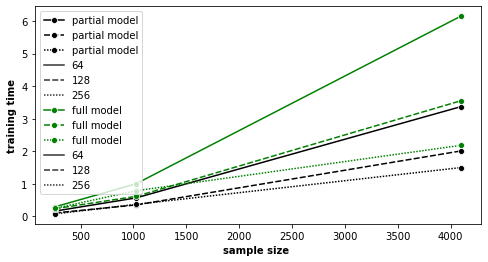

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns

#sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(8, 4))
#plt.scatter(intervention_set,np.exp(np.array(error_partial)),label='partial model',color='black',ls='-',marker='o')
#plt.scatter(intervention_set,np.exp(np.array(error_full)),label='full model',color='yellow',ls='--',marker='*')
sns.lineplot(data=time_train,x='sample_size',y='time_partial',style="batch_size",label='partial model',color='black',marker='o',palette="flare")
sns.lineplot(data=time_train,x='sample_size',y='time_full',style="batch_size",label='full model',color='green',marker='o',palette="flare")

plt.xlabel('sample size ',fontweight='bold')
plt.ylabel('training time',fontweight='bold')
plt.legend()
#fig.savefig(experiment_name+'/counterfactual_errors.pdf',format='pdf',pad_inches=0.1,bbox_inches='tight',dpi=1200)

<AxesSubplot:xlabel='sample_size', ylabel='training time'>

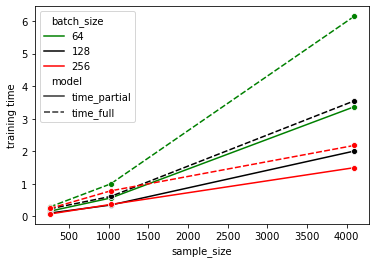

In [61]:
import seaborn as sns
import matplotlib 


sns.lineplot(
    data=time_train_modified, x="sample_size", y="training time",marker='o',style='model',hue="batch_size",
    palette=['green','black','red'] #"husl",#size=3#hue_norm=matplotlib.colors.Normalize()#kind='line'

)
